
# Preparations

In [1]:
import Pkg
Pkg.DEFAULT_IO[] = stdout;

### Fetch files and packages

In [2]:
using Plots
using Statistics
using StatsBase

In [3]:
include("../Codebase/Functions/file_managment_functions.jl");
include("Functions/data_handling_functions.jl");
include("Functions/color_codes.jl");
include("Functions/behaviour_plotting_functions.jl");

### Sets Dataset

In [4]:
target_folder = "BehaviourMap"

S_grid = 10 .^(range(-1,stop=2,length=300))
D_grid = 10 .^(range(-1,stop=2,length=300))
τ_grid = [0.1,0.15,0.20,0.30,0.50,0.75,1.0,1.5,2.0,3.0,5.0,7.50,10.0,15.0,20.0,30.0,50.0,75.0,100.0]
v0_grid = [0.01,0.02,0.03,0.05,0.075,0.1,0.15,0.20]
n_grid = [2.0,3.0,4.0]
η_grid = [0.001,0.002,0.005,0.01,0.02,0.05,0.1]

dataset = DataSet(target_folder,S_grid,D_grid,τ_grid,v0_grid,n_grid,η_grid);

In [5]:
# Sets all behaviours.
list_of_behaviours = [:no_activation, :single_response_pulse, :stochastic_pulsing, :oscillation, :stochastic_anti_pulsing, :homogeneous_activation, :heterogeneous_activation, :stochastic_switching, :stable_bistability, :homogeneous_intermediate_activation];

### Plot settings

In [6]:
gr(); 
mm = Plots.mm
default(fmt = :png,framestyle=:box,grid=false,xguidefontsize=16,yguidefontsize=16,titlefontsize=18);

In [7]:
red_scale_4 = [RGB{Float64}(1.0,0.6,0.6),RGB{Float64}(1.0,0.4,0.4),RGB{Float64}(1.0,0.2,0.2),RGB{Float64}(0.66,0.,0.),RGB{Float64}(0.33,0.,0.)];
green_blue_scale_4 = [RGB{Float64}(0.,1.,0.0),RGB{Float64}(0.,0.66,0.33),RGB{Float64}(0.,0.33,0.66),RGB{Float64}(0.4,0.4,1.)];
blue_scale_3 = [RGB{Float64}(0.,0.7,0.7) RGB{Float64}(0.,.0,1.) RGB{Float64}(0.7,0.0,0.7)];

### Declares functions

In [8]:
# For a parameter set, returns the 4 paraemters τ, v0, n, η.
function get_τ_v0_n_η(parameters)
    (length(parameters)==4) && return parameters
    (length(parameters)==6) && return parameters[3:6]
    error("Paraemter entry set have weird length (nether 4 nor 6).")
end;

In [9]:
# Fits a line to datapoints
function get_linedata(DSs)
    N = length(DSs)
    (N<5) && return (a=0.0, b=0.0, N=N, er=Inf)
    xi = first.(DSs); yi = last.(DSs);    
    a,b = get_line(xi,yi)
    er = sum((yi .- (a*xi .+ b) ) .^2)/N
    return (;a,b,N,er)    
end
function get_line(xi,yi)
    A = [xi ones(length(xi))]
    return A\yi
end;

In [10]:
# Gets the mean lines as a parameter is varried.
idxs = Vector{Any}([1:19,1:8,1:3,1:7])
function mean_vals(line_analysis,p_idx)
    map(i -> mean_val(line_analysis[setindex!(copy(idxs),i,p_idx)...]), 1:size(line_analysis)[p_idx])
end
function mean_vals(all_linedata,trans,p_idx)
    map(i -> mean_val(all_linedata[trans][setindex!(copy(idxs),i,p_idx)...]), 1:size(all_linedata[trans])[p_idx])
end
function mean_val(line_analysis)
    filtered = filter(line -> line.er < 1.0, collect(line_analysis))
    return (a=mean(getfield.(filtered,:a)),b=mean(getfield.(filtered,:b)),N=mean(getfield.(filtered,:N)),er=mean(getfield.(filtered,:er)))
end;

In [11]:
# Plots data in various ways.
function plt_ab_prog(lines)
    p1 = plot(getfield.(mean_line,:a),ylimit=(0.0,2maximum(getfield.(mean_line,:a))))
    p2 = plot(getfield.(mean_line,:b),ylimit=(0.0,2maximum(getfield.(mean_line,:b))))
    p3 = plot(getfield.(mean_line,:a),getfield.(mean_line,:b),xlimit=(0.0,2*maximum(getfield.(mean_line,:a))),ylimit=(0.0,2*maximum(getfield.(mean_line,:b))))
    plot(p1,p2,p3,lw=5,size=(1200,300),layout=(1,3))
end
function plot_lines(lines)
    plot()
    for (idx,line) in enumerate(lines)
        c_frac = (idx-1) / (length(lines)-1)
        plot!(x->line.a*x+line.b,color=RGB{Float64}(c_frac,0,1.0-c_frac),label="",xaxis=:log10,yaxis=:log10,xlimit=(0.1,100.0),ylimit=(1.0,100.0))
    end
    plot!()
end
function plot_line(line;kwargs...)
    plot(x->line.a*x+line.b;xaxis=:log10,yaxis=:log10,xlimit=(0.1,100.0),ylimit=(1.0,100.0),kwargs...)
end
function plot_line!(line;kwargs...)
    plot!(x->line.a*x+line.b;xaxis=:log10,yaxis=:log10,xlimit=(0.1,100.0),ylimit=(1.0,100.0),kwargs...)
end;

function plot_lines(trans,dataset,p_idx,all_linedata,transition_pointsl;lw=2,la=0.8)
    mean_lines = mean_vals(all_linedata,trans,p_idx)
    N = length(mean_lines)
    color_scale = map(n -> RGB{Float64}(1.0-(n-1)/(N-1),(n-1)/(N-1),1.0-(n-1)/(N-1)), 1:N)
    plot()
    for (idx,line) in enumerate(mean_lines)
        (line.N < 100) && continue
        Dlims = get_Dlims(transition_points,trans,p_idx,idx)
        plot!(x->line.a*x+line.b,Dlims...,color=color_scale[idx],lw=lw,la=la,label="",xaxis=:log10,yaxis=:log10,xticks=[],yticks=[],xlimit=(0.1,100.0),ylimit=(1.0,100.0))
    end
    plot!()
end
function plot_ab_all_params(trans,dataset,all_linedata;amax=2.0,bmax=10.0)
    ab_plots = map(p_idx -> plot_ab_one_params(trans,dataset,p_idx,all_linedata;amax=amax,bmax=bmax), 1:4)
    plot(ab_plots...,layout=(1,4),size=(2000,350))
end
function plot_ab_one_params(trans,dataset,p_idx,all_linedata;amax=2.0,bmax=10.0)
    mean_line = mean_vals(all_linedata[trans],p_idx)
    xgrid = dataset.p_grids[2+p_idx]; xaxis = (p_idx==3 ? :identity : :log10)
    plot(xgrid,getfield.(mean_line,:a))
    pa = plot!(xgrid,getfield.(mean_line,:a),seriestype=:scatter,color=1,ylimit=(0.0,amax),xaxis=xaxis)
    pb = plot(xgrid,getfield.(mean_line,:b),color=2)
    pb = plot!(xgrid,getfield.(mean_line,:b),seriestype=:scatter,color=2,ylimit=(0.0,bmax),xaxis=xaxis)
    plot(pa,pb,layout=(2,1),label="",xlimit=(xgrid[1],xgrid[end]),lw=5,xticks=[],size=(500,300))
end
function plot_lines_all_params(trans,dataset,all_linedata,transition_points;amax=2.0,bmax=10.0)
    line_plots = map(p_idx -> plot_lines_one_params(trans,dataset,p_idx,all_linedata,transition_points;amax=amax,bmax=bmax), 1:4)
    plot(line_plots...,layout=(1,4),size=(2000,500))
end
pab_colors = [[:skyblue1,:blue2],[:salmon1,:red2],[:green1,:green],[:plum2,:purple]]
function plot_lines_one_params(trans,dataset,p_idx,all_linedata,transition_points;amax=2.0,bmax=10.0,lw_l=4,la_l=0.7,lw_ab=10,la_ab=0.7,ms=8)
    pl = plot_lines(trans,dataset,p_idx,all_linedata,transition_points,lw=lw_l,la=la_l)
    xgrid = deepcopy(dataset.p_grids[2+p_idx]); xaxis = (p_idx==3 ? :identity : :log10)
    N = length(xgrid)
    color_scale = map(n -> RGB{Float64}(1.0-(n-1)/(N-1),(n-1)/(N-1),1.0-(n-1)/(N-1)), 1:N)
    xS=xgrid[1]; xE=xgrid[end];
    mean_line = mean_vals(all_linedata,trans,p_idx)
    foreach(idx -> (mean_line[idx].N < 100) && (deleteat!(xgrid,idx);deleteat!(mean_line,idx);deleteat!(color_scale,idx);), length(xgrid):-1:1)
    display("$(p_idx):        1 = $(mean_line[1].a), b1 = $(mean_line[1].b)         a2 = $(mean_line[end].a), b2 = $(mean_line[end].b)")
    plot(xgrid,5*getfield.(mean_line,:a),label="",lw=lw_ab,la=la_ab,color=pab_colors[p_idx][1])
    plot!(xgrid,5*getfield.(mean_line,:a),seriestype=:scatter,color=color_scale,ylimit=(0.0,amax),xaxis=xaxis,label="",markerstrokealpha=0.5,markersize=ms)
    plot!(xgrid,getfield.(mean_line,:b),color=pab_colors[p_idx][2],label="",lw=lw_ab,la=la_ab)
    pab = plot!(xgrid,getfield.(mean_line,:b),seriestype=:scatter,markersize=ms,markerstrokealpha=0.5,color=color_scale,ylimit=(-0.5,bmax),label="",xaxis=xaxis,yticks=[],xlimit=(0.98*xS,1.02*xE),xticks=[])
    plot(pl,pab,size=(500,500),layout=@layout [a{0.66h};b])
end;

In [12]:
# General helper functions.
function get_Dlims(transition_points,trans,p_idx_idx,p_idx)
    all_points = sort(first.(vcat(vec(transition_points[trans][setindex!(copy(idxs),p_idx,p_idx_idx)...])...)))
    return (percentile(all_points,1),percentile(all_points,99))
end;

# Analysis

### Generates transition and line data

In [13]:
transitions = Vector{Pair{Symbol,Symbol}}()
foreach(b1 -> foreach(b2 -> push!(transitions,b1=>b2), list_of_behaviours), list_of_behaviours)

In [14]:
transition_points = Dict{Pair{Symbol,Symbol},Array{Vector{Tuple{Float64,Float64}},4}}()
foreach(trans -> transition_points[trans] = [Vector{Tuple{Float64,Float64}}() for i in 1:length(dataset.τ_grid), j in 1:length(dataset.v0_grid), k in 1:length(dataset.n_grid), l in 1:length(dataset.η_grid)],transitions);
@time for (τi,τ) in enumerate(dataset.τ_grid), (v0i,v0) in enumerate(dataset.v0_grid), (ni,n) in enumerate(dataset.n_grid), (ηi,η) in enumerate(dataset.η_grid)
    bg = BehaviourGrid([τ,v0,n,η],dataset);
    if bg.file_existed 
        for (Di,D) in enumerate(dataset.D_grid[1:end]), (Si,S) in enumerate(dataset.S_grid[1:end-1])
            (bg.behaviours[Si,Di] == bg.behaviours[Si+1,Di]) && continue
            !in(bg.behaviours[Si,Di],list_of_behaviours) || !in(bg.behaviours[Si+1,Di],list_of_behaviours) && continue
            push!(transition_points[bg.behaviours[Si,Di] => bg.behaviours[Si+1,Di]][τi,v0i,ni,ηi],(D,S))
        end
    else
        println("Missing file for: $([τ,v0,n,η])")
    end
end
serialize("Data/transition_points.jls",transition_points);

809.888833 seconds (3.47 G allocations: 109.617 GiB, 1.74% gc time, 0.05% compilation time)


In [15]:
transition_points = deserialize("Data/transition_points.jls");

In [16]:
all_linedata = Dict{Pair{Symbol, Symbol},Array{NamedTuple{(:a, :b, :N, :er), Tuple{Float64, Float64, Int64, Float64}}, 4}}()
foreach(t -> all_linedata[t] = get_linedata.(transition_points[t]), transitions);

### Filters out less interesting transitions

In [78]:
function larger_than_reverse(tc,t_counts)
    (tc[1] == (:homogeneous_intermediate_activation => :oscillation)) && return true
    (tc[1] == (:oscillation => :homogeneous_intermediate_activation)) && return true
    return Dict(t_counts)[tc[1]] > Dict(t_counts)[reverse(tc[1])]    
end;

In [79]:
trans_counts = map(trans -> trans => length(vcat(vec(transition_points[trans])...)),transitions);
trans_counts_filt1 = filter(tc -> larger_than_reverse(tc,trans_counts), trans_counts)
trans_counts_filt2 = filter(tc -> tc[2] > 1000, trans_counts_filt1)
trans_counts_filt3 = filter(tc -> mean(filter(x->x!=Inf,getfield.(all_linedata[tc[1]],:er))) < 1.0, trans_counts_filt2)
sorted_transitions = sort(trans_counts_filt3,by=x->-x[2])
for trans in sorted_transitions
    println(trans[1],"\t\t\t",trans[2],"\t\t\t", mean(filter(x->x!=Inf,getfield.(all_linedata[trans[1]],:er))))
end

:no_activation => :stable_bistability			351372			0.036512622288723914
:heterogeneous_activation => :homogeneous_activation			321327			0.0007081609188147552
:stable_bistability => :heterogeneous_activation			272292			0.00035440392592293066
:no_activation => :stochastic_pulsing			242073			0.08852055268578306
:stochastic_pulsing => :oscillation			242051			0.25329714393269365
:stochastic_anti_pulsing => :homogeneous_activation			215812			0.23769255359543412
:oscillation => :stochastic_anti_pulsing			200767			0.5186801314265095
:homogeneous_intermediate_activation => :homogeneous_activation			135444			0.016837603355908136
:no_activation => :homogeneous_intermediate_activation			124724			0.20199449613683498
:no_activation => :single_response_pulse			103933			0.09111323725120811
:oscillation => :homogeneous_activation			95710			0.04058217583911591
:no_activation => :homogeneous_activation			81993			0.12032012962616682
:stable_bistability => :homogeneous_activation			79009			1.80273128237969e-

### Make line scetch figure

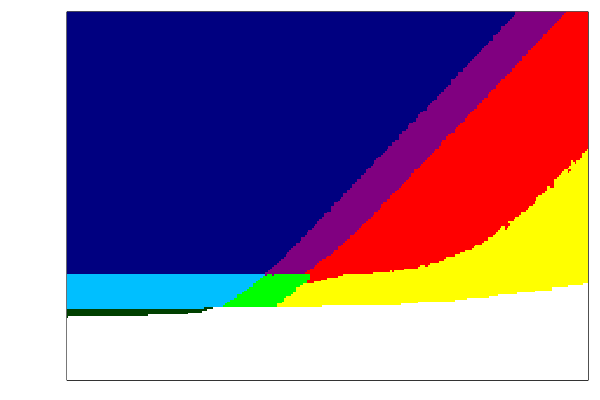

In [23]:
params = [5.0,0.05,3,0.1];
bg = BehaviourGrid(params,dataset);
behaviour_grid_plot = plot!(plot_behaviour_grid(bg,start_s_slice=100,idx_axis=false,xguide="",yguide="",xticks=[],yticks=[]),size=(600,400))


:no_activation => :stable_bistability
0.3052339631652402          2.1038545602653778

:heterogeneous_activation => :homogeneous_activation
-3.200933099033076e-16          3.67466194073669

:stable_bistability => :heterogeneous_activation
0.04749497431800505          2.358354842277193

:no_activation => :stochastic_pulsing
0.009492772466448349          2.4512408360916638

:stochastic_pulsing => :oscillation
0.14264326184019963          2.4889017463297054

:stochastic_anti_pulsing => :homogeneous_activation
2.51813290492174          0.08395463058406696

:oscillation => :stochastic_anti_pulsing
1.3140725829882551          0.18415094734404844


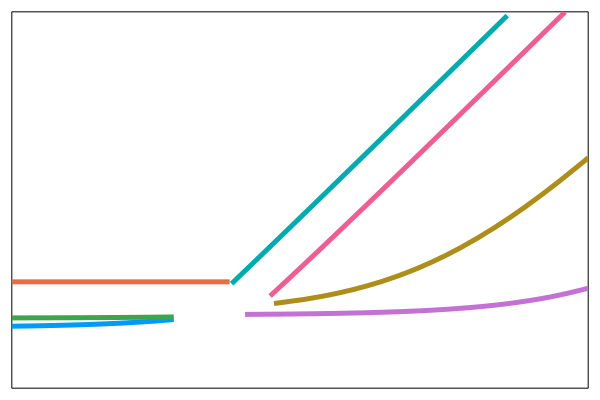

In [184]:
plot()
for trans in first.(sorted_transitions[1:7])
    line = all_linedata[trans][findfirst(dataset.τ_grid.==5.0),findfirst(dataset.v0_grid.==0.05),findfirst(dataset.n_grid.==3),findfirst(dataset.η_grid.==0.1)]
    tps = transition_points[trans][findfirst(dataset.τ_grid.==5.0),findfirst(dataset.v0_grid.==0.05),findfirst(dataset.n_grid.==3),findfirst(dataset.η_grid.==0.1)]
    plot!(x->line.a*x+line.b,minimum(first.(tps)),maximum(first.(tps)),xlimit=(0.1,100.0),ylimit=(1.0,100.0),xaxis=:log10,yaxis=:log10,xguide="",yguide="",xticks=[],yticks=[],size=(600,400),label="",lw=5)
    println("\n",trans)
    println(line.a,"          ",line.b)
end
line_examples_plot = plot!()

In [151]:
save_figure(behaviour_grid_plot,"Transition_Line_Parameter_Dependence";tag="behaviourgrid_")
save_figure(line_examples_plot,"Transition_Line_Parameter_Dependence";tag="lines_")

### Make parameter and line plot

:no_activation => :stable_bistability

"1:        1 = 0.5271853937082296, b1 = 1.532552001823642         a2 = 0.7077034857100057, b2 = 1.4874403795624003"

"2:        1 = 1.000932505606201, b1 = 1.4709837429195756         a2 = 0.2091971487460519, b2 = 1.347173876082228"

"3:        1 = 0.3780959548774269, b1 = 1.7576336844460876         a2 = 0.785051600900643, b2 = 1.3301876489095148"

"4:        1 = 0.6213513646358206, b1 = 1.416307326363261         a2 = 0.5979729730796763, b2 = 2.086840615032182"

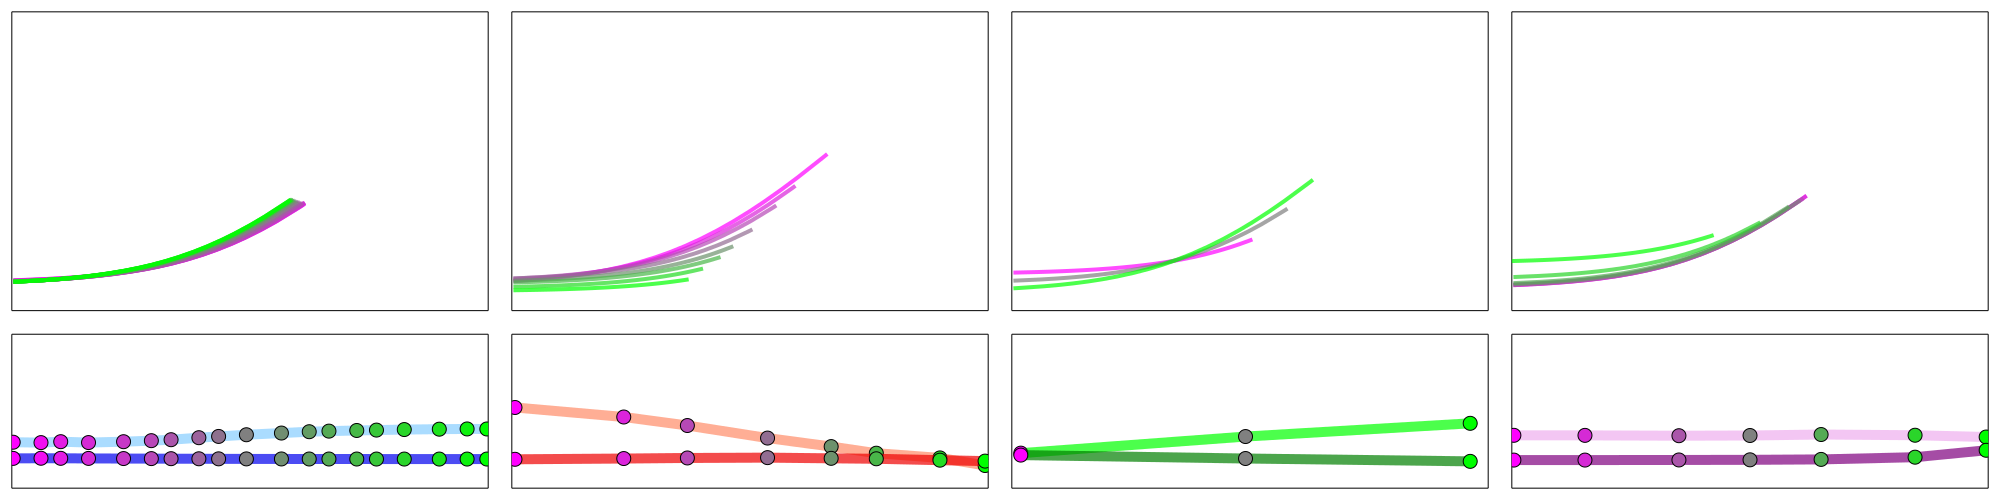

:heterogeneous_activation => :homogeneous_activation

"1:        1 = 0.00268729455819313, b1 = 5.100910009639968         a2 = 0.000374846349219005, b2 = 5.28244641814027"

"2:        1 = 0.00020090829131753555, b1 = 11.21792505191401         a2 = 0.00014869644225826197, b2 = 1.8067679990672687"

"3:        1 = 0.0025081792946194258, b1 = 3.015467478420039         a2 = 0.00013709691268241593, b2 = 7.180267947845745"

"4:        1 = 0.003788218802361694, b1 = 6.5463918870268625         a2 = 0.00042623495203389996, b2 = 4.524933544781975"

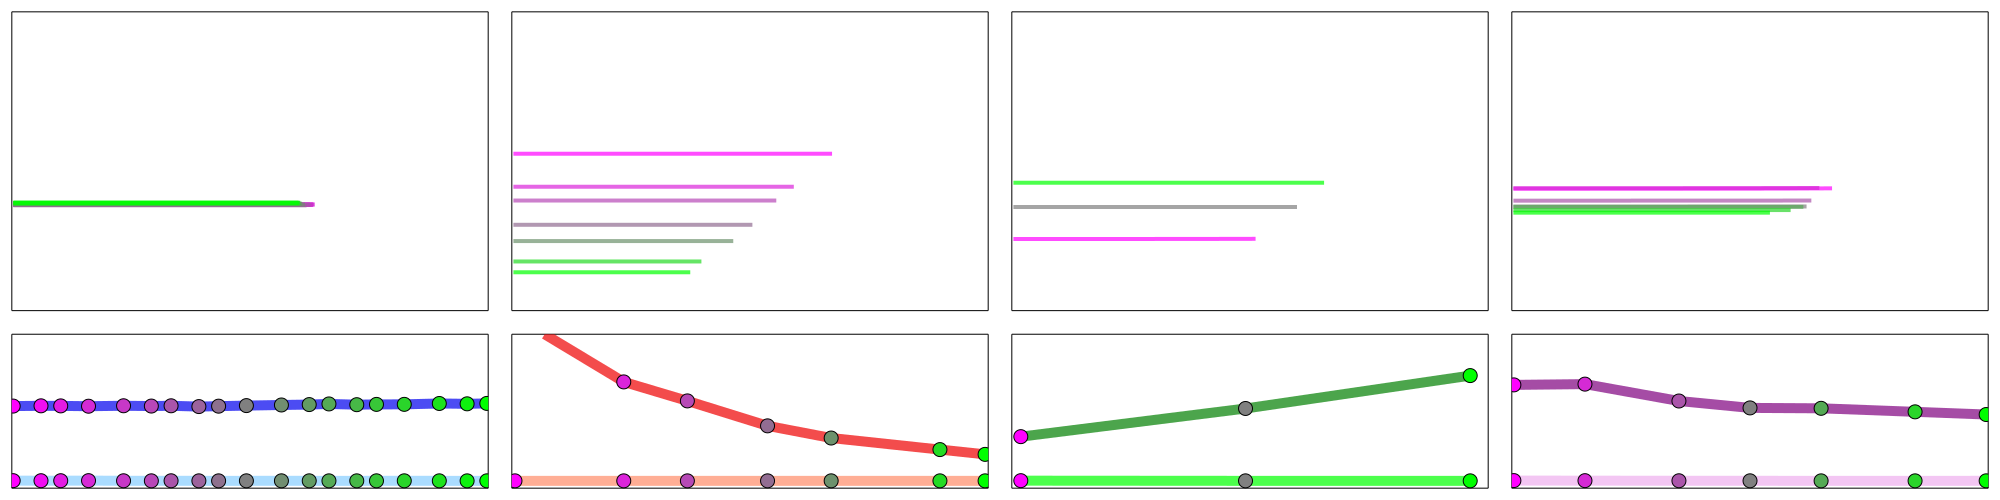

:stable_bistability => :heterogeneous_activation

"1:        1 = 0.029606478274783826, b1 = 4.661866296727741         a2 = 0.017856532525646663, b2 = 4.784351344364603"

"2:        1 = 0.03005424353070436, b1 = 9.191979768863641         a2 = 0.01060116422437778, b2 = 1.6956266348136173"

"3:        1 = 0.021510760970216695, b1 = 2.859320866482637         a2 = 0.025557388374005764, b2 = 6.190497433447405"

"4:        1 = -1.6607552581637457e-16, b1 = 6.817109628277452         a2 = 0.11584654634919546, b2 = 3.131353535344482"

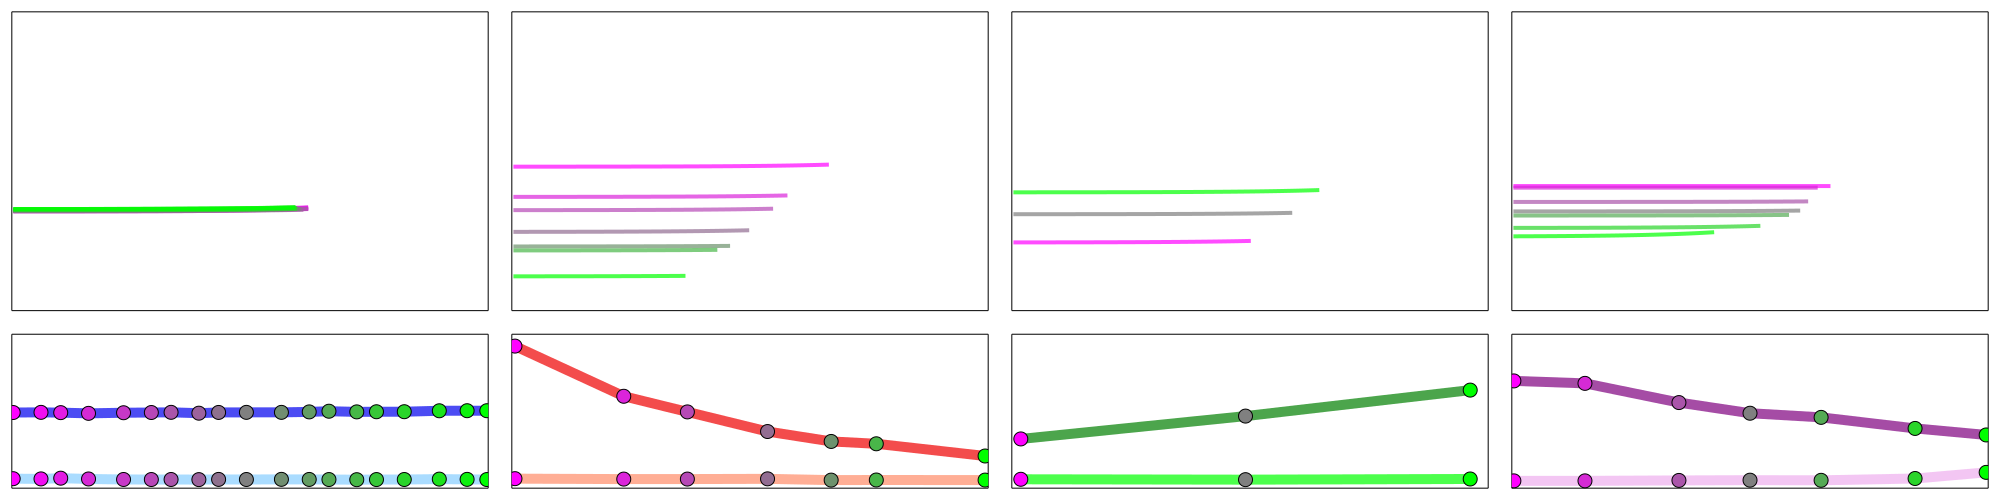

:no_activation => :stochastic_pulsing

"1:        1 = 0.22334277655506862, b1 = 2.089088771156285         a2 = 0.06711750686380237, b2 = 3.918945921609634"

"2:        1 = 0.054556905386524975, b1 = 5.262350849106351         a2 = 0.19996745155796347, b2 = 1.0542023626297965"

"3:        1 = 0.05614426331062769, b1 = 2.5345504378754002         a2 = 0.1201063299956319, b2 = 4.862811124225197"

"4:        1 = 0.13241579488276864, b1 = 4.0217304566510865         a2 = 0.06635961748837121, b2 = 2.3896432687342193"

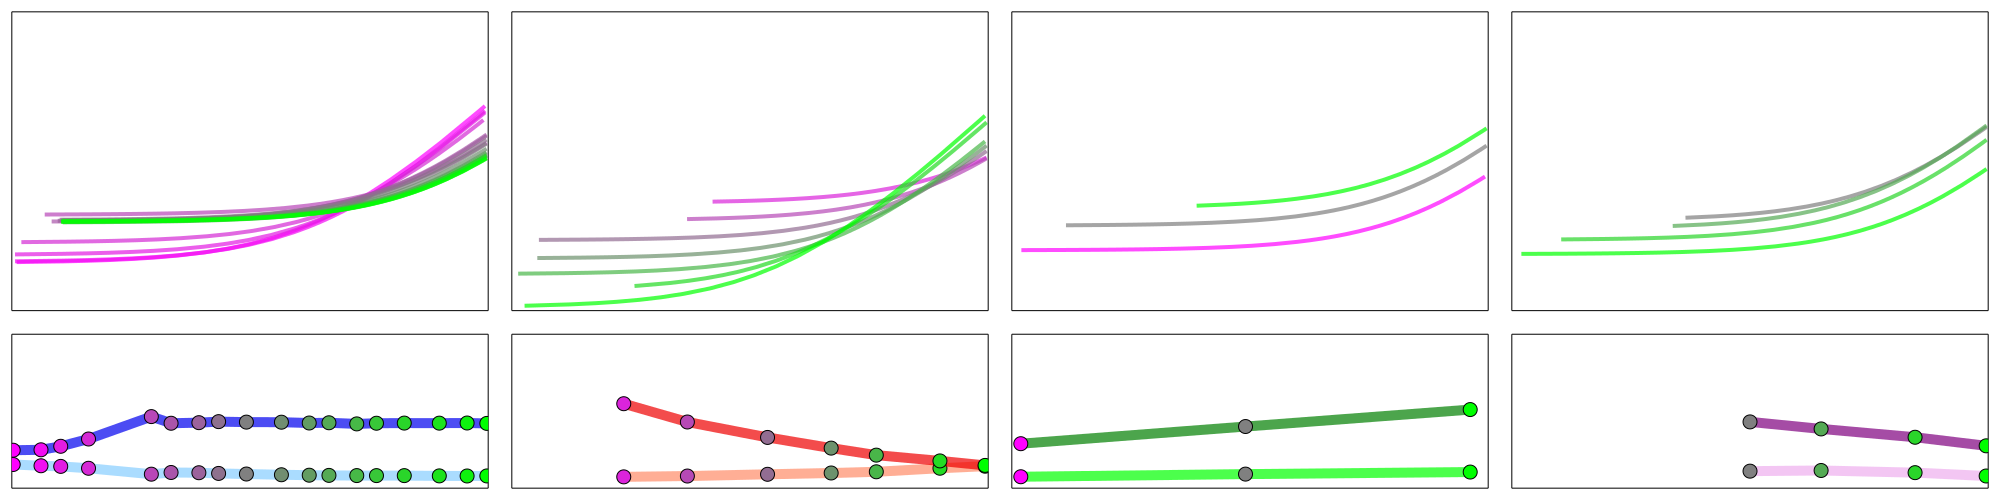

:stochastic_pulsing => :oscillation

"1:        1 = 0.2709889196282877, b1 = 2.9474018171820733         a2 = 0.20482883846944447, b2 = 3.373597887202262"

"2:        1 = 0.20651478377013024, b1 = 2.3834394703237765         a2 = 0.4040640382758502, b2 = 0.641319848499056"

"3:        1 = 0.15315969789091763, b1 = 2.2965820603123457         a2 = 0.2619572487828257, b2 = 4.278991258518863"

"4:        1 = 0.2207194126573615, b1 = 3.478335267112401         a2 = 0.21730086915981758, b2 = 2.6258798153185117"

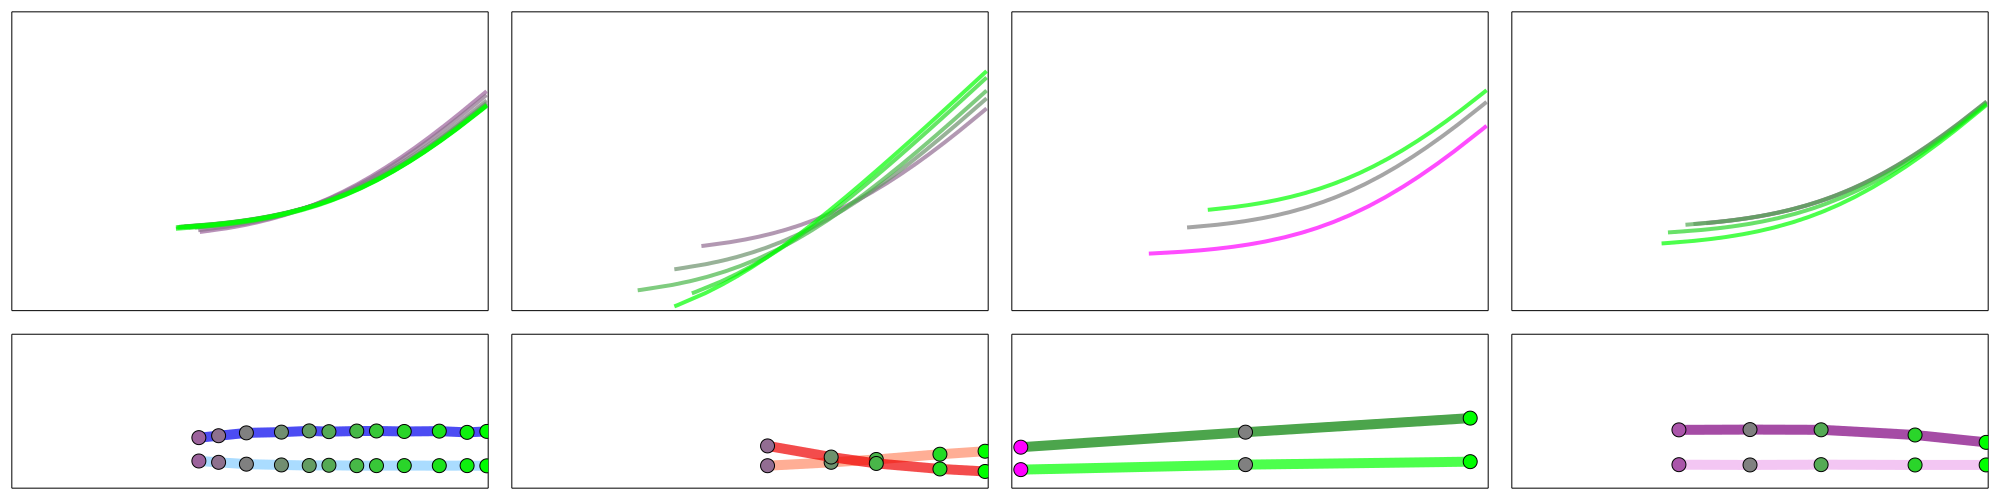

:stochastic_anti_pulsing => :homogeneous_activation

"1:        1 = 1.2465486109842832, b1 = 0.3212093480293963         a2 = 1.6757397559011058, b2 = 0.14063480517499402"

"2:        1 = 1.6665943549432856, b1 = 0.12511008877546573         a2 = 1.5445481846166034, b2 = 0.10898252690096537"

"3:        1 = 1.3941851965340497, b1 = 0.3555403675655454         a2 = 1.7178076500060198, b2 = 0.020591185917755456"

"4:        1 = 1.3863121047465716, b1 = 0.07875976884630687         a2 = 2.186433664386511, b2 = 0.20464797669092327"

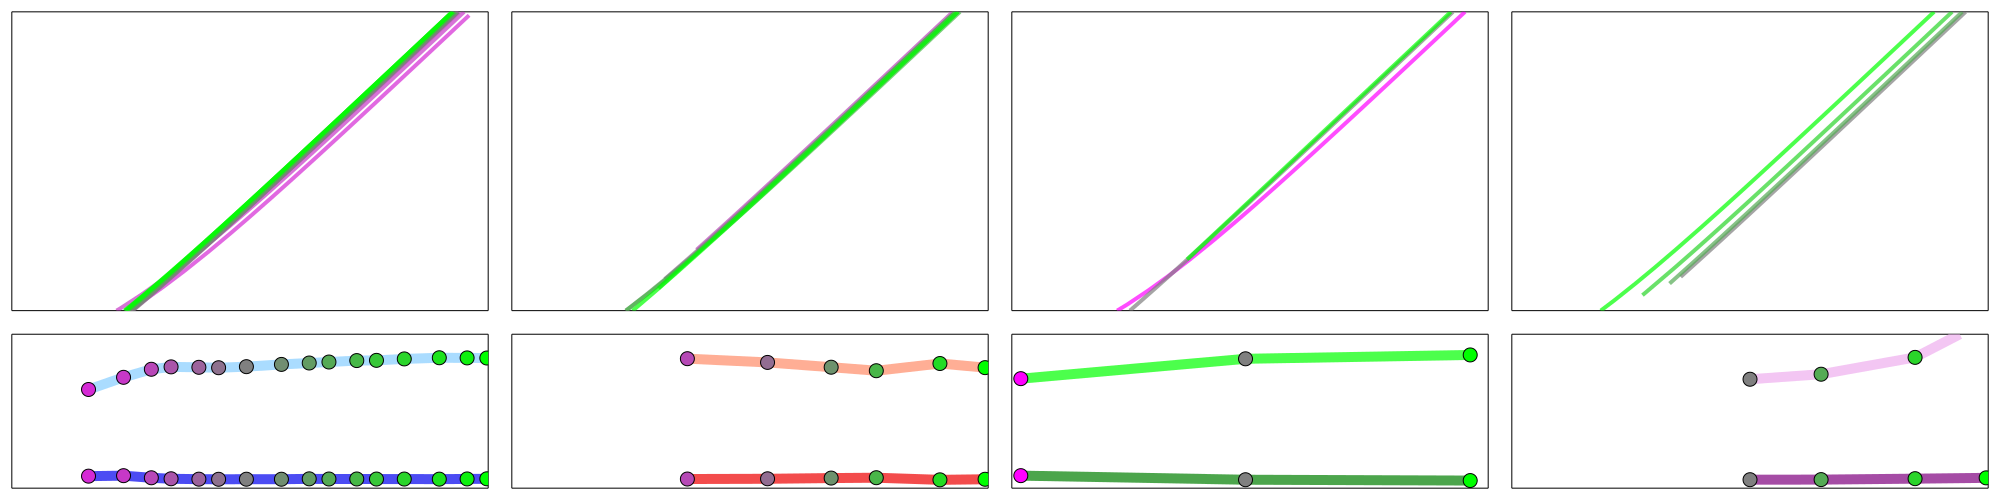

:oscillation => :stochastic_anti_pulsing

"1:        1 = 1.1340966027850985, b1 = 0.2712830564988758         a2 = 1.4287464772007246, b2 = 0.1420193902210816"

"2:        1 = 1.2995438617333908, b1 = 0.17916924701241194         a2 = 1.257229274042984, b2 = 0.11934142424725892"

"3:        1 = 1.071734425724942, b1 = 0.38853659615552083         a2 = 1.4362298818695702, b2 = 0.04708420418230197"

"4:        1 = 1.3410446402094887, b1 = 0.07960233261801203         a2 = 1.132734933960895, b2 = 0.4339556191114041"

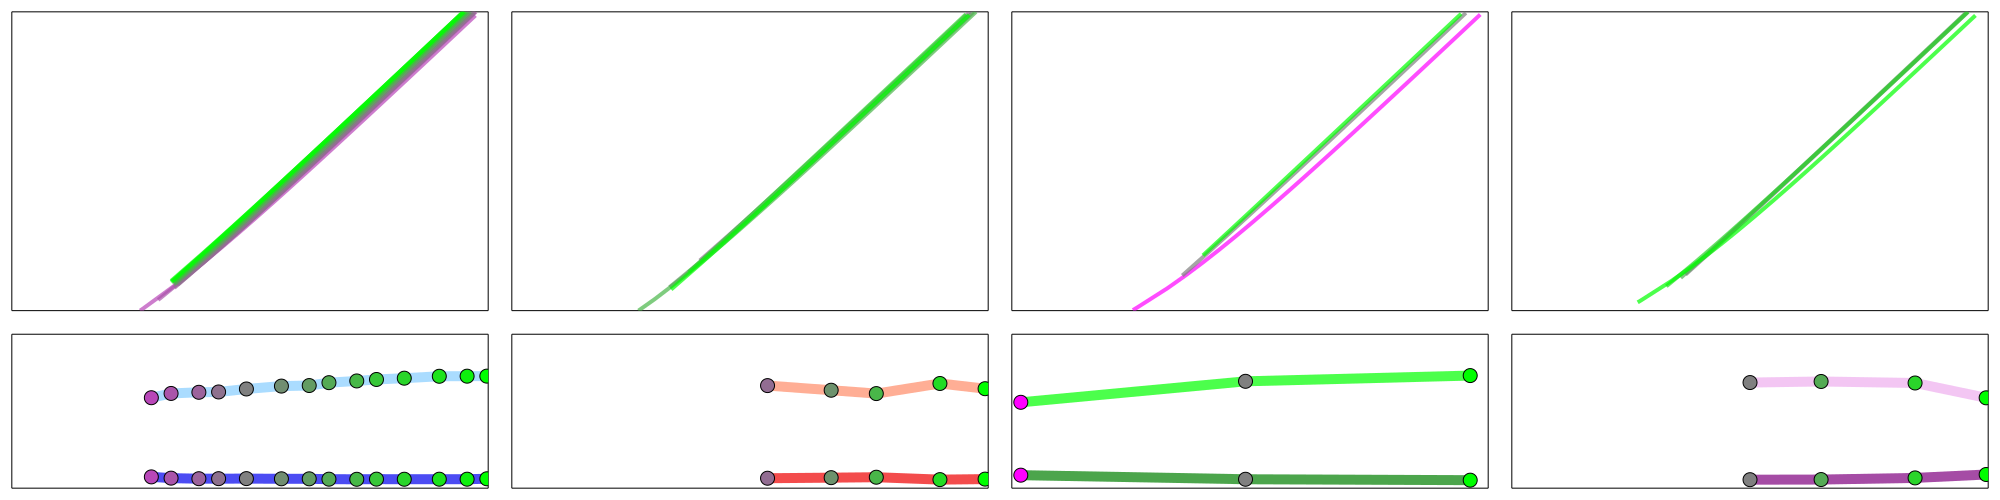

In [216]:
for trans in first.(sorted_transitions[1:7])
    display(trans)
    parameter_line_plot = plot_lines_all_params(trans,dataset,all_linedata,transition_points)
    display(parameter_line_plot)
    save_figure(parameter_line_plot,"Transition_Line_Parameter_Dependence/$(trans[1])___$(trans[2])")
end

### Linear space plot

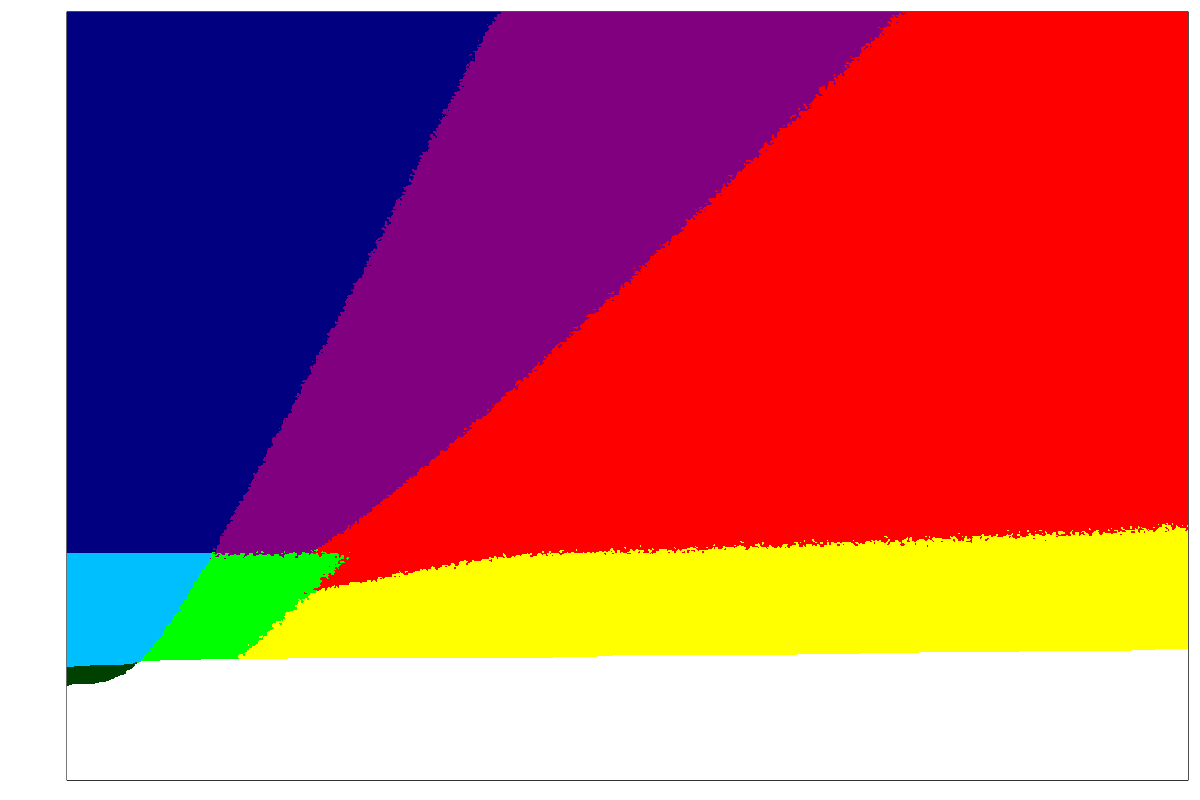

In [81]:
dataset_lin = DataSet("LinearMap",range(0.1,stop=10.0,length=1000),range(0.1,stop=10.0,length=1000),[5.0],[0.05],[3.0],[0.1]);
bg_lin = BehaviourGrid([5.0,0.05,3.0,0.1],dataset_lin);
foreach(i -> (bg_lin.behaviours[371,i]==:heterogeneous_activation) && (bg_lin.behaviours[371,i]=:homogeneous_activation), 1:1000)
lin_behaviour_grid_plot = plot!(plot_behaviour_grid(bg_lin,start_s_slice=100,xguide="",yguide="",xticks=[],yticks=[]),size=(1200,800))

In [82]:
tps = Vector{Tuple{Float64,Float64}}()
for (Di,D) in enumerate(dataset_lin.D_grid[1:end]), (Si,S) in enumerate(dataset_lin.S_grid[1:end-1])
    if (bg_lin.behaviours[Si,Di]==:no_activation) && (bg_lin.behaviours[Si+1,Di]==:stable_bistability)
       push!(tps,(D,S)) 
    end
end

In [105]:
DSs = tps;
N = length(DSs)
xi = first.(DSs); yi = last.(DSs);    
A = [xi ones(length(xi))]
a,b = A\yi
er = sum((yi .- (a*xi .+ b) ) .^2)/N;
a,b

(0.3401625837635949, 2.105262595342788)

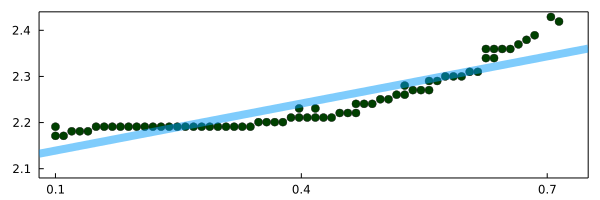

In [101]:
scatter(DSs,color=RGB{Float64}(0,0.25,0),ms=5)
NA_SB_line_plot = plot!(x->a*x+b,0.07,0.9,color=1,lw=8,la=0.5,xlimit=(0.08,0.75),ylimit=(2.08,2.44),legend=:none,size=(600,200),xticks=[0.1,0.4,0.7],yticks=[2.1,2.2,2.3,2.4])

In [106]:
save_figure(lin_behaviour_grid_plot,"Transition_Line_Parameter_Dependence/Linear_Space";tag="linspace_")
save_figure(NA_SB_line_plot,"Transition_Line_Parameter_Dependence/Linear_Space";tag="SB_NB_line_")

In [103]:
[range(1.0,stop=10.0,length=6)...]'

1×6 adjoint(::Vector{Float64}) with eltype Float64:
 1.0  2.8  4.6  6.4  8.2  10.0

In [104]:
[range(0.1,stop=10.0,length=9)...]'

1×9 adjoint(::Vector{Float64}) with eltype Float64:
 0.1  1.3375  2.575  3.8125  5.05  6.2875  7.525  8.7625  10.0